### AI Financial Analyst with the Assistants API

Concepts Tested For This Challenge Project:
- Parallel Function Calling
- Assistants API
- Code Integrator
- Fully Typed and ReUsable Code
- Show Images if Requested in Prompt and Generated
- Handle Exceptions

In [1]:
import os
import json
import requests
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

_ : bool = load_dotenv(find_dotenv()) # read local .env file

FMP_API_KEY: str = os.environ.get("FMP_API_KEY")

client : OpenAI = OpenAI()

# display(FMP_API_KEY)
# display(client.api_key)

In [14]:
# Defining Functions to Get Data from REST APIs
# We are not using ~ period and limit parameters as the API Requires a Premium Account for these parameters

# STEP 0 === Define financial statement functions
def get_income_statement(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())

def get_balance_sheet(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())

def get_cash_flow_statement(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?period=annual&apikey=ETZqiw9M5ObXGLxKylHzoI5Ec70NQFue"
    response = requests.get(url)
    return json.dumps(response.json())

def get_key_metrics(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())

def get_financial_ratios(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/ratios-ttm/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())

def get_financial_growth(ticker: str) -> str:
    url = f"https://financialmodelingprep.com/api/v3/financial-growth/{ticker}?period=annual&apikey={FMP_API_KEY}"
    response = requests.get(url)
    return json.dumps(response.json())


In [15]:
# Map available functions
available_functions = {
    "get_income_statement": get_income_statement,
    "get_balance_sheet": get_balance_sheet,
    "get_cash_flow_statement": get_cash_flow_statement,
    "get_key_metrics": get_key_metrics,
    "get_financial_ratios": get_financial_ratios,
    "get_financial_growth": get_financial_growth
}

In [16]:
# A Class to Manage All Open API Assistant Calls and Functions
from openai.types.beta.threads import Run
from openai.types.beta.thread import Thread
from openai.types.beta.assistant_create_params import Tool

import time

class FinancialAssistantManager:
    def __init__(self, model: str = "gpt-4-1106-preview"):
        self.client = OpenAI()
        self.model = model
        self.assistant = None
        self.thread = None
        self.run = None

    def create_assistant(self, name: str, instructions: str, tools: list[Tool]) -> None:
        self.assistant = self.client.beta.assistants.create(
            name=name,
            instructions=instructions,
            tools=tools,
            model=self.model
        )

    def create_thread(self) -> Thread:
        self.thread = self.client.beta.threads.create()
        return self.thread

    def add_message_to_thread(self, role: str, content: str) -> None:
        self.client.beta.threads.messages.create(
            thread_id=self.thread.id,
            role=role,
            content=content
        )

    def run_assistant(self, instructions: str) -> Run:
        self.run = self.client.beta.threads.runs.create(
            thread_id=self.thread.id,
            assistant_id=self.assistant.id,
            instructions=instructions
        )
        return self.run

    def wait_for_completion(self, run: Run, thread: Thread) -> Run:

        while run.status in ["in_progress", "queued"]:
            run_status = self.client.beta.threads.runs.retrieve(
                thread_id=self.thread.id,
                run_id=self.run.id
            )
            print(f"Run is {run.status}. Waiting...")
            time.sleep(3)  # Wait for 3 seconds before checking again

            if run_status.status == 'completed':
                processed_response = self.process_messages()
                return processed_response
                # break
            elif run_status.status == 'requires_action':
                print("Function Calling ...")
                self.call_required_functions(run_status.required_action.submit_tool_outputs.model_dump())
            elif run.status == "failed":
                print("Run failed.")
                break
            else:
                print(f"Waiting for the Assistant to process...: {run.status}")

    def process_messages(self) -> None:
        messages = self.client.beta.threads.messages.list(thread_id=self.thread.id)
        return messages

    def call_required_functions(self, required_actions):
        tool_outputs = []

        for action in required_actions["tool_calls"]:
            function_name = action['function']['name']
            arguments = json.loads(action['function']['arguments'])
            print('function_name', function_name)
            print('function_arguments', arguments)

            if function_name in available_functions:
                    function_to_call = available_functions[function_name]
                    output = function_to_call(**arguments)
                    tool_outputs.append({
                        "tool_call_id": action['id'],
                        "output": output,
                    })

            else:
                raise ValueError(f"Unknown function: {function_name}")

        print("Submitting outputs back to the Assistant...")
        self.client.beta.threads.runs.submit_tool_outputs(
            thread_id=self.thread.id,
            run_id=self.run.id,
            tool_outputs=tool_outputs
        )



In [18]:
# Show Messages and Plot Images in Financial Analysis If ANY

import requests
from PIL import Image
from IPython.display import Image, display


def download_and_save_image(file_id, save_path):
    """
    Downloads an image from OpenAI using its file ID and saves it to the specified path.

    Args:
    - file_id (str): The ID of the file to download.
    - save_path (str): The path where the image will be saved.

    Returns:
    - None
    """
    # Construct the URL to download the image
    download_url = f"https://api.openai.com/v1/files/{file_id}/content"

    # Perform the HTTP GET request to download the image
    response = requests.get(download_url, headers={"Authorization": f"Bearer {os.environ.get("OPENAI_API_KEY")}"})

    # Check if the request was successful
    if response.status_code == 200:
        # Write the image to the specified file
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Image downloaded and saved to {save_path}")
    else:
        print(f"Failed to download image: HTTP Status Code {response.status_code}")


def pretty_print(messages):
    print("# Messages")
    for message in messages.data:
        role_label = "User" if message.role == "user" else "Assistant"
        # Check the type of message content and handle accordingly
        for content in message.content:
            if content.type == "text":
                message_content = content.text.value
                print(f"{role_label}: {message_content}\n")
                print()
            elif content.type == "image_file":
                # Handle image file content, e.g., print the file ID or download the image
                image_file_id = content.image_file.file_id
                # Define a path to save the image
                image_save_path = f"image_{image_file_id}.png"
                # Download and save the image
                print(f"{role_label}: Image file ID: {image_file_id}")
                download_and_save_image(image_file_id, image_save_path)

                # Display the image within Jupyter Notebook
                display(Image(filename=image_save_path))

                #   # Open and display the image
                # try:
                #     img = Image.open(image_save_path)
                #     img.show()
                # except IOError:
                #     print("Error in opening the image file.")

In [6]:
financial_tools = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "get_income_statement",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_balance_sheet",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_cash_flow_statement",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_key_metrics",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_financial_ratios",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_financial_growth",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                },
                "required": ["ticker"],
            }
        }
    }
]

In [19]:
INSTRUCTIONS = "Act as a financial analyst by accessing detailed financial data through the Financial Modeling Prep API. Your capabilities include analyzing key metrics, comprehensive financial statements, vital financial ratios, and tracking financial growth trends. "

In [20]:
def fmp_financial_analyst(prompt: str):
    fmp_analyst = FinancialAssistantManager()

    fmp_analyst.create_assistant(
        name="Financial Analyst",
        instructions=INSTRUCTIONS,
        tools=financial_tools
    )

    fmp_analyst.create_thread()

    fmp_analyst.add_message_to_thread(
        role="user",
        content=prompt
    )

    run = fmp_analyst.run_assistant(
        instructions=INSTRUCTIONS
    )

    final_res = fmp_analyst.wait_for_completion(
        run=run,
        thread=fmp_analyst.thread
    )

    return final_res
    

In [21]:
analysis1 = fmp_financial_analyst("Can you compare the financial health of Microsoft and Apple over the last four years, focusing on their balance sheets and key financial ratios?")

Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Function Calling ...
function_name get_balance_sheet
function_arguments {'ticker': 'MSFT'}
function_name get_balance_sheet
function_arguments {'ticker': 'AAPL'}
function_name get_financial_ratios
function_arguments {'ticker': 'MSFT'}
function_name get_financial_ratios
function_arguments {'ticker': 'AAPL'}
Submitting outputs back to the Assistant...
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Function Calling ...
function_name get_key_metrics
function_arguments {'ticker': 'MSFT'}
function_name get_key_metrics
function_arguments {'ticker': 'AAP

In [22]:
pretty_print(analysis1)

# Messages
Assistant: After gathering the data for Microsoft (MSFT) and Apple (AAPL) for the past four years regarding their balance sheets and key financial ratios, let's conduct a comparison focusing on their financial health.

### *Balance Sheet Comparison*

We will compare key indicators such as total assets, total liabilities, and shareholders' equity.

#### Microsoft (MSFT)
- **2023:**
  - Total Assets: \$411.98 billion
  - Total Liabilities: \$205.75 billion
  - Total Shareholders' Equity: \$206.22 billion
- **2022:**
  - Total Assets: \$364.84 billion
  - Total Liabilities: \$198.30 billion
  - Total Shareholders' Equity: \$166.54 billion
- **2021:**
  - Total Assets: \$333.78 billion
  - Total Liabilities: \$191.79 billion
  - Total Shareholders' Equity: \$141.99 billion
- **2020:**
  - Total Assets: \$301.31 billion
  - Total Liabilities: \$183.01 billion
  - Total Shareholders' Equity: \$118.30 billion

#### Apple (AAPL)
- **2023:**
  - Total Assets: \$352.58 billion
  - Tot

In [12]:
response2 = fmp_financial_analyst("""Evaluate Microsoft vs. Googles's revenue & profitability} growth over the past 4 quarters. Visualize the results with one or more charts.""")

Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Function Calling ...
function_name get_income_statement
function_arguments {'ticker': 'MSFT'}
function_name get_income_statement
function_arguments {'ticker': 'GOOGL'}
Submitting outputs back to the Assistant...
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting...
Waiting for the Assistant to process...: queued
Run is queued. Waiting

# Messages
Assistant: Image file ID: file-SEniaDqVXBjBcupOkuvDgT8h
Image downloaded and saved to image_file-SEniaDqVXBjBcupOkuvDgT8h.png


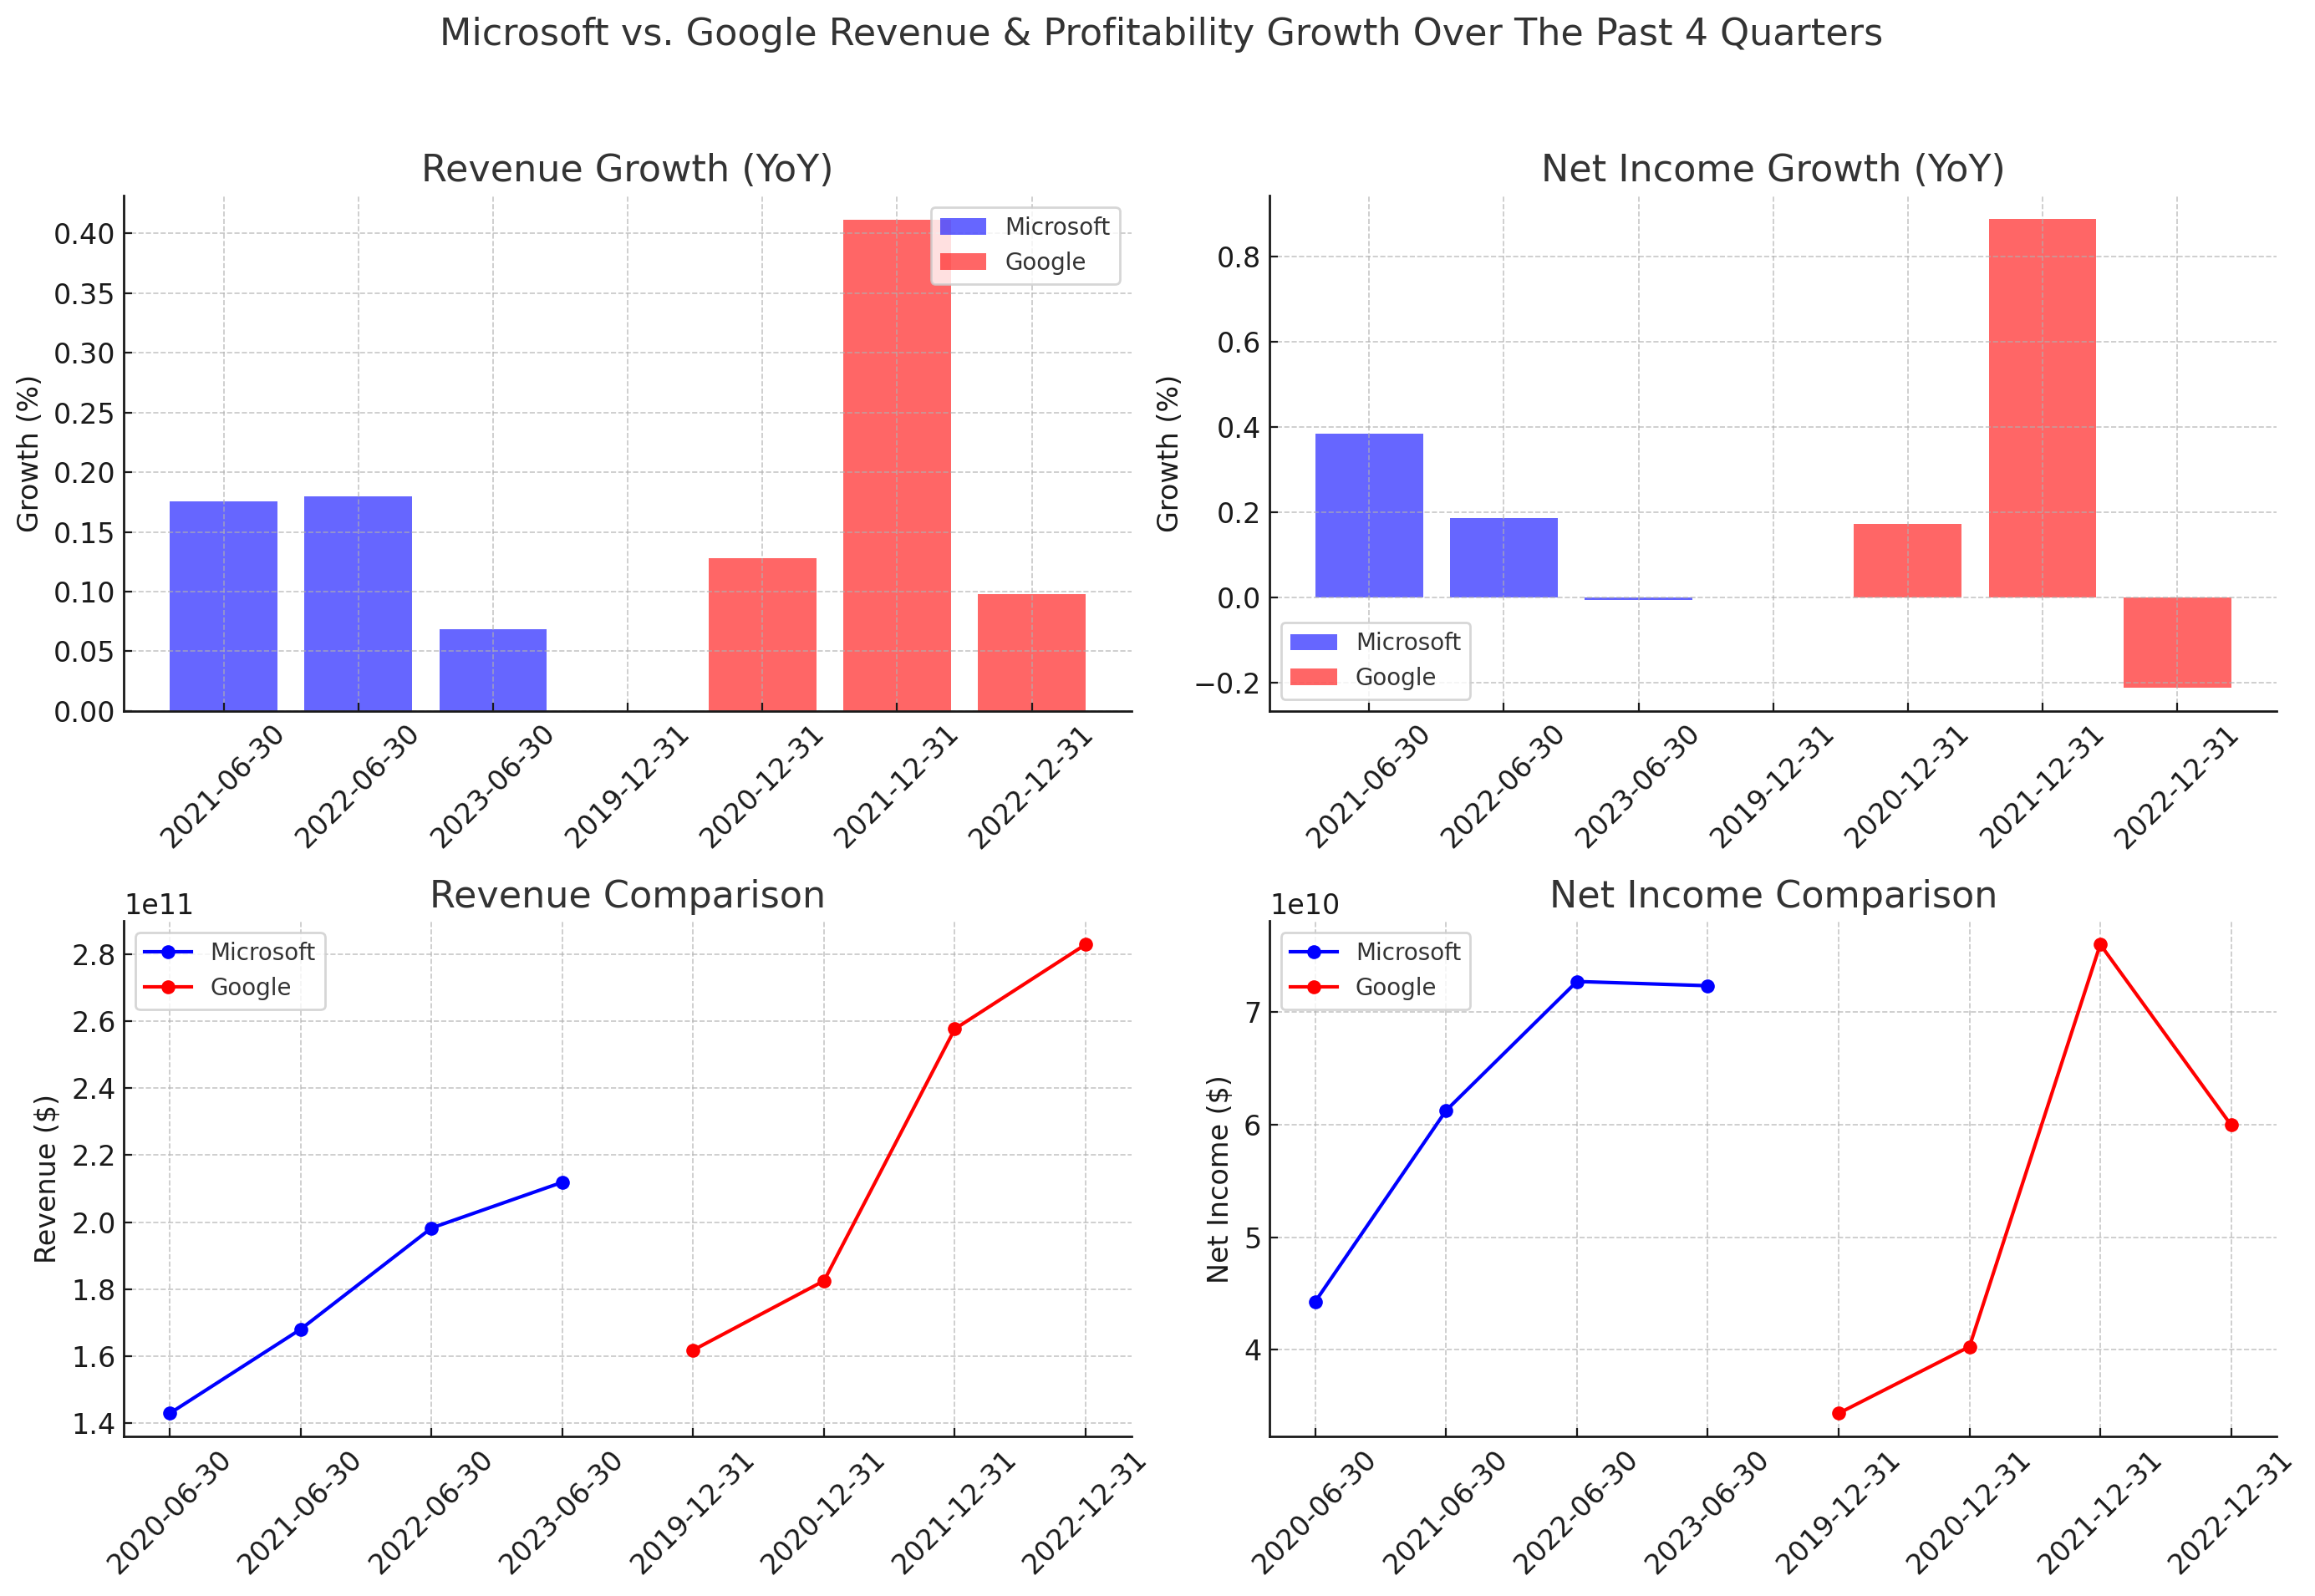

Assistant: Here are the charts analyzing the revenue and profitability growth of Microsoft (MSFT) and Google (GOOGL) over the past 4 quarters:

1. **Revenue Growth (Year over Year - YoY)**: The bar charts show the comparisons in the growth of revenue for the two companies. It's clear from the charts that both companies have experienced growth in their revenue, although the specifics can differ between the quarters.

2. **Net Income Growth (YoY)**: Similarly, this set of bar charts compares the growth in net income. Both companies seem to have fluctuations in their net income growth, which is typical as it can be influenced by a variety of factors beyond just revenue, like costs, taxes, and extraordinary items.

3. **Revenue Comparison**: The line charts compare the actual revenue figures for the companies across the quarters. Google's revenue is consistently higher than Microsoft's over the reported periods.

4. **Net Income Comparison**: When looking at net income, Microsoft and Googl

In [13]:
pretty_print(response2)